In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
houses = pd.read_csv('Casas_venezuela.csv')
apartments = pd.read_csv('Departamentos_venezuela.csv')

In [3]:
def graph_categorical_relations(df, features):
    for col in features:
        fig = plt.figure(figsize=(9,6))
        ax = fig.gca()

        if df[col].dtype == "object":
            grouped = df.groupby(col)
            df2 = pd.DataFrame({col:vals['Precio'] for col,vals in grouped})
            medians = df2.median()
            medians.sort_values(ascending=True, inplace=True)
            df2 = df2[medians.index]
            df2.boxplot(ax=ax)
        else:
            df.boxplot(column = 'Precio', by = col, ax=ax)

        ax.set_ylabel('Precio')
        ax.get_yaxis().set_major_formatter(lambda x, pos: f'{x:.0f}')

        if len(ax.get_xticklabels()) > 10 and any([len(str(label.get_text())) >= 5 for label in ax.get_xticklabels()]):
            ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
        elif len(ax.get_xticklabels()) > 5 and any([len(str(label.get_text())) >= 5 for label in ax.get_xticklabels()]):
            ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

        ax.set_title('Precio en función de ' + col)
    plt.show()

In [4]:
from scipy.stats import linregress

In [5]:
def graph_numeric_relations(df, features):
    for col in features:
        fig = plt.figure(figsize=(9,6))
        ax = fig.gca()

        feature = df[col]

        try:
            feature = df[col].astype(int)
            label = df['Precio']
        except pd.errors.IntCastingNaNError:
            feature = df[ df[col].notnull() ][col]
            label = df[ df[col].notnull() ]['Precio']

        corr = feature.corr(label)

        plt.scatter(x=feature, y=label)

        lin_reg = linregress(x=feature, y=label)
        line = [ lin_reg.slope * xi + lin_reg.intercept for xi in feature ]
        ax.plot(feature, line, color='red')

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.95, f'Correlación: {corr}\n'+r'$R^{2}$'+f': {lin_reg.rvalue**2:.4f}', transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)

        ax.set_xlabel(col)
        ax.set_ylabel('Precio')
        ax.ticklabel_format(style='plain')
        ax.set_title(f'Precio en función de {col}')
    plt.show()

# Casas

In [6]:
mask_price = ((houses['Precio'] <= houses['Precio'].quantile(q=0.95)) & (houses['Precio'] >= houses['Precio'].quantile(q=0.05)))
mask_area = ((houses['Área Privada'] <= houses['Área Privada'].quantile(q=0.95)) & (houses['Área Privada'] >= houses['Área Privada'].quantile(q=0.05)))
mask_terrain = ((houses['Terreno'] <= houses['Terreno'].quantile(q=0.95)) & (houses['Terreno'] >= houses['Terreno'].quantile(q=0.05)))

houses = houses[mask_area & mask_price & mask_terrain]

In [7]:
houses.shape

(3379, 16)

In [8]:
houses.head()

,Precio,Codígo RAH,Tipo de Propiedad,Estilo,Área Privada,Terreno,Estado Del Inmueble,Dormitorios,Total Baños,Baños Completos,Tipo De Estacionamiento,Amoblado,Dormitorio De Servicio,Calle,Puestos De Estacionamiento,Medios Baños
2,160000,VE 23-26676,Casa,Duplex,230,250,Usado,5,3,3,Cubierto,Si,Si,Cerrada con Vigilancia,2.0,0.0
3,180000,VE 23-26673,Casa,1 Nivel,367,367,Usado,4,4,3,Cubierto,No,No,Cerrada con Vigilancia,4.0,1.0
4,75000,VE 23-26665,Casa,Duplex,286,800,Usado,4,4,4,Descubierto,No,Si,Calle Ciega,6.0,0.0
6,17500,VE 23-26656,Casa,1 Nivel,190,274,Usado,3,3,2,Descubierto,No,No,Cerrada con Vigilancia,2.0,1.0
7,180000,VE 23-26652,Casa,1 Nivel,197,197,Usado,4,3,3,Descubierto,No,Si,Publica,6.0,0.0


Voy a definir las columnas que en principio parecen interesantes para el modelo.

In [9]:
house_numeric_features = ['Área Privada', 'Terreno']
houses_ordinal_features = ['Dormitorios', 'Total Baños', 'Puestos De Estacionamiento']
houses_categorical_features = ['Estilo', 'Estado Del Inmueble', 'Tipo De Estacionamiento', 'Calle', 'Estado', 'Ciudad']

Ahora voy a graficar su comportamiento con el precio para ver si realmente son utiles o no.

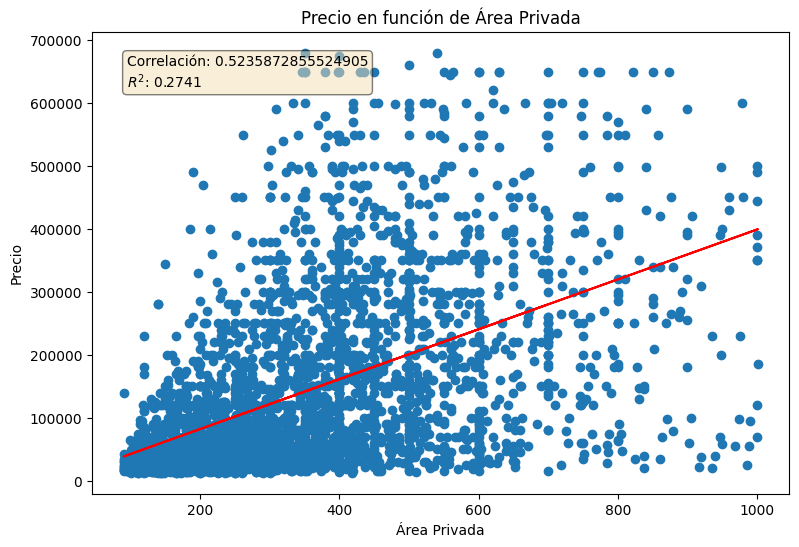

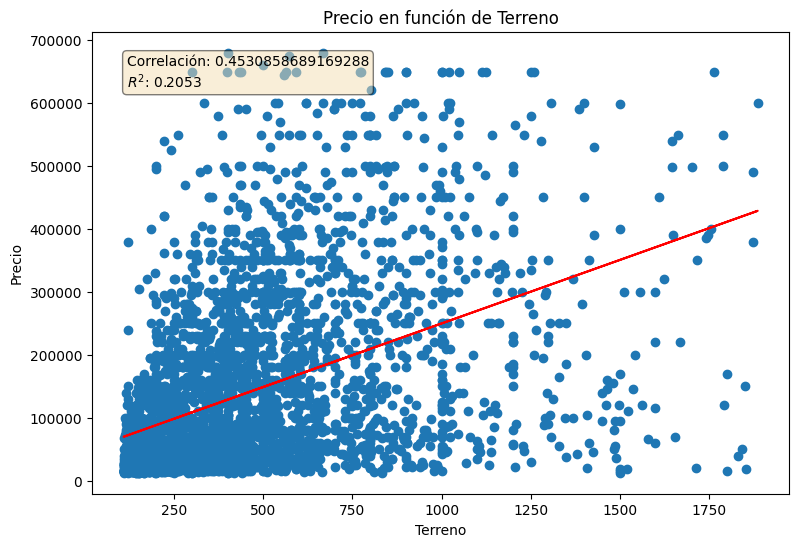

In [10]:
graph_numeric_relations(houses, house_numeric_features)

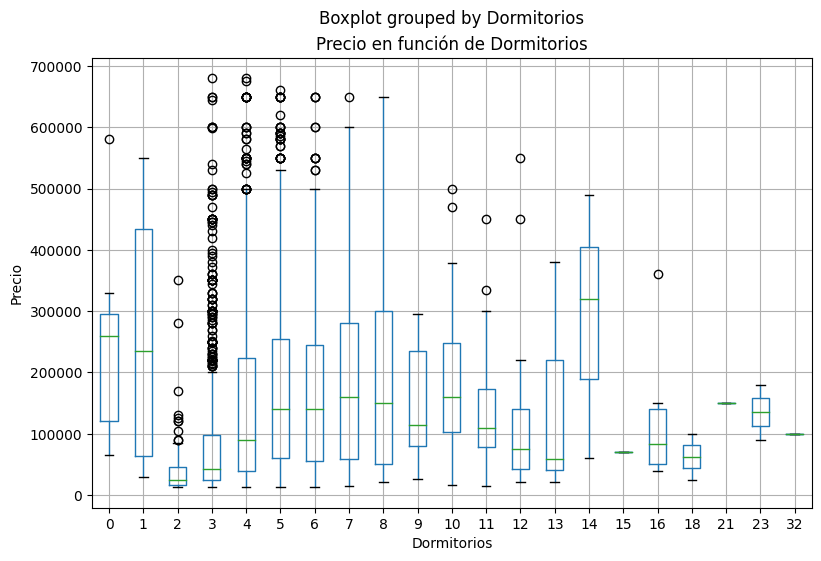

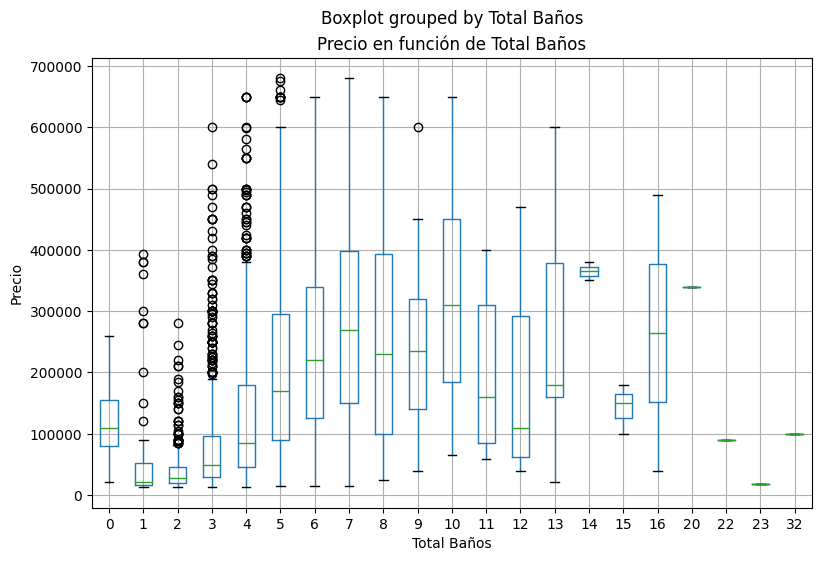

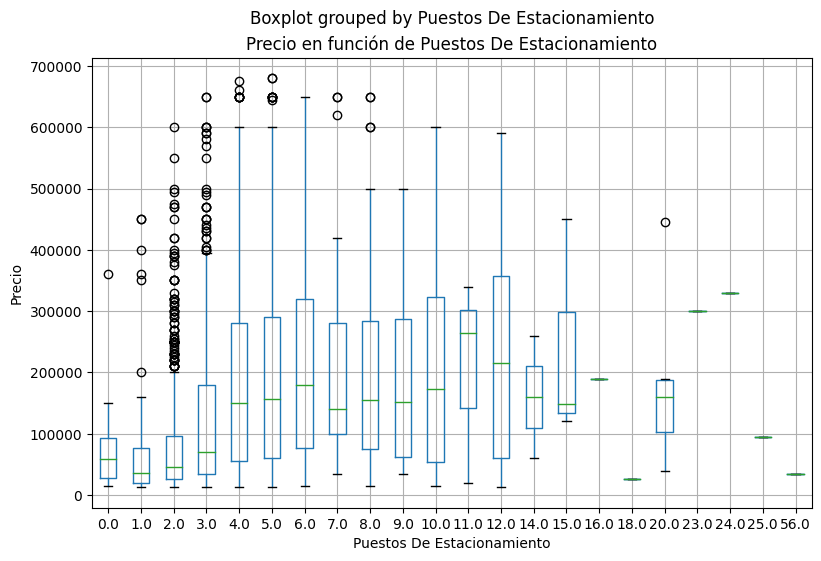

In [11]:
graph_categorical_relations(houses, houses_ordinal_features)

KeyError: 'Estado'

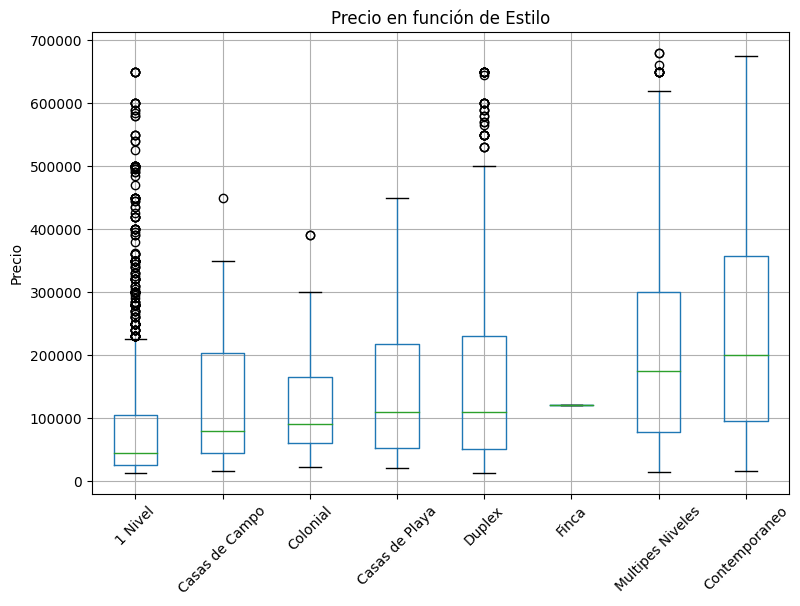

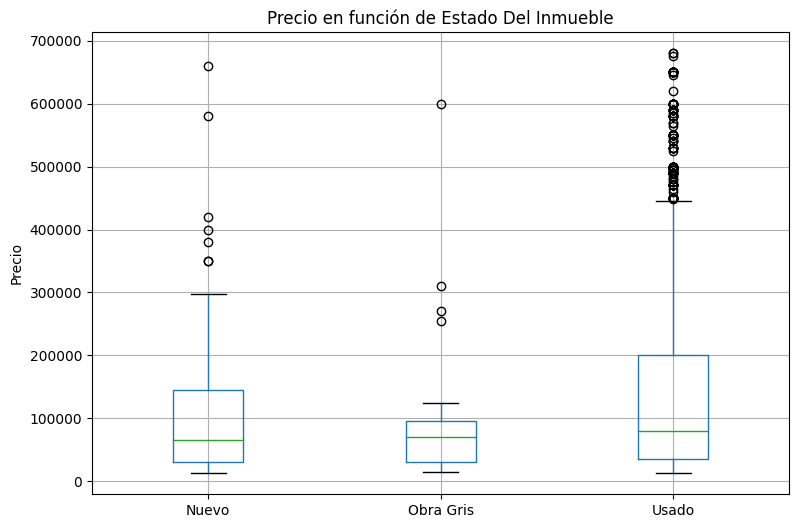

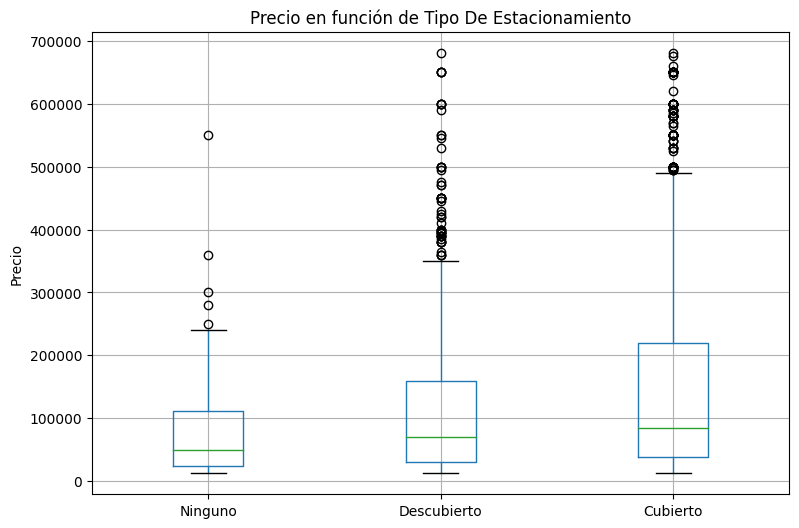

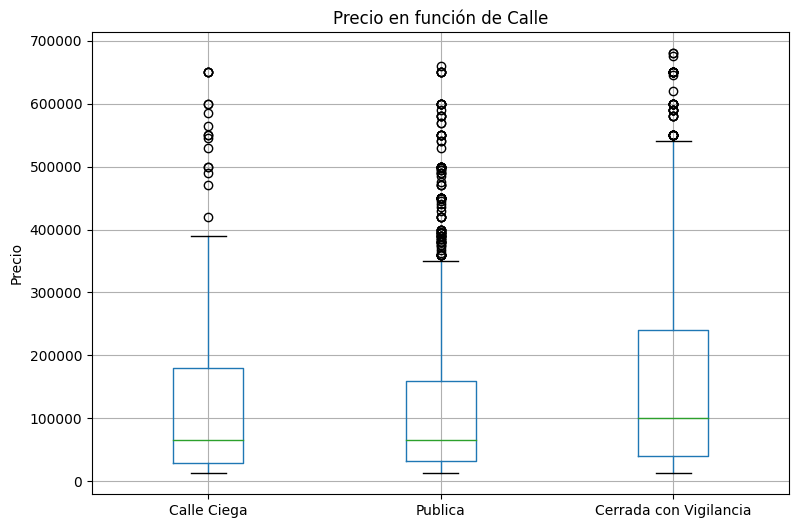

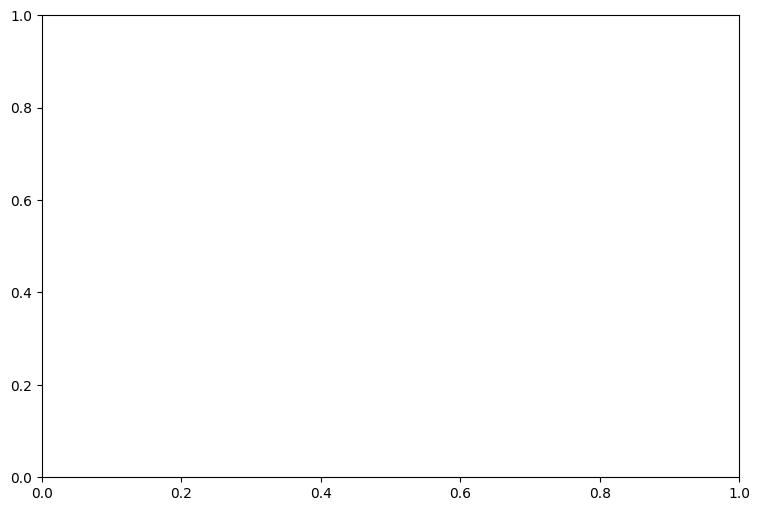

In [13]:
graph_categorical_relations(houses, houses_categorical_features)

Para las casas, la calle no parecen tener mucho efecto en el precio de la misma, por lo tanto no va a ser considerada para el entrenamiento de los modelos.  
Se va a considerar solo la ciudad ya que esta depende del estado, y el tipo de estacionamiento no es definitorio, sino si tiene o no estacionamiento, lo cual esta ya marcado por la columna "Puestos De Estacionamiento".

Por lo visto anteriormente, voy a quedarme con todas las columnas numericas, todas las ordinales y solo el estilo y ciudad para las categoricas.

In [254]:
houses_categorical_features = ['Estilo', 'Ciudad']

Se puede observar como el precio de la casa aumenta con el terreno y área de la misma. Pero el área de la casa, así como todas las variables ordinales, es generalmente linealmente dependiente con el terreno de la misma.

In [255]:
def graph_area_relation(df, features):
    for col in features:
        fig = plt.figure(figsize=(5,5))
        ax = plt.gca()
        plt.scatter(houses['Área Privada'], houses[col])
        ax.set_xlabel('Área Privada')
        ax.set_ylabel(col)
        ax.set_title(col + ' en función del área')
        trend = np.polyfit(houses.loc[houses[col].notnull(), 'Área Privada'], houses.loc[houses[col].notnull(), col], 1)
        p = np.poly1d(trend)
        plt.plot(houses['Área Privada'], p(houses['Área Privada']), color='red')
    plt.show()

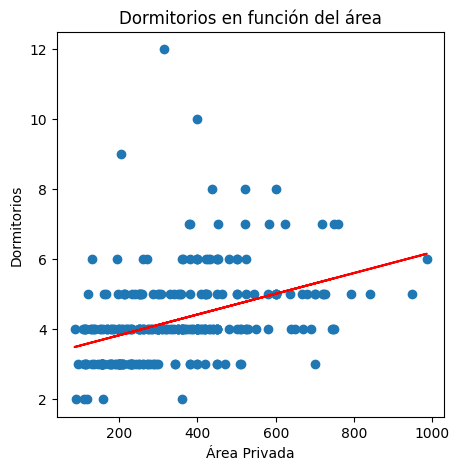

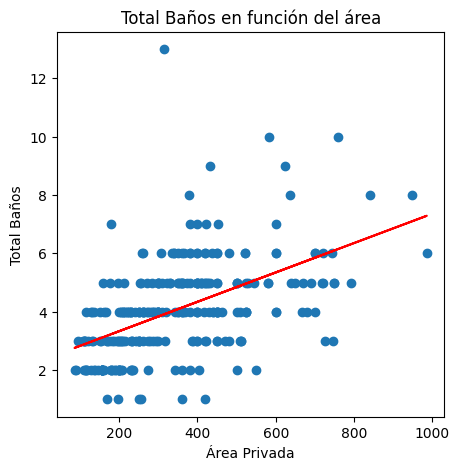

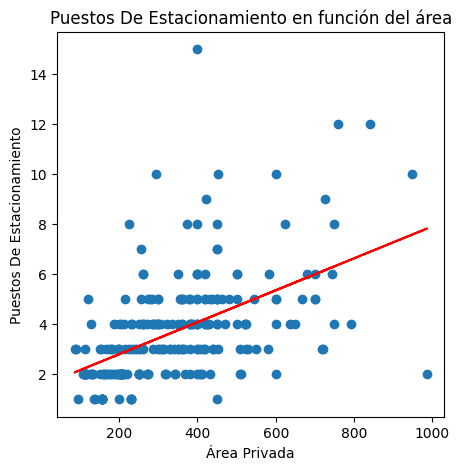

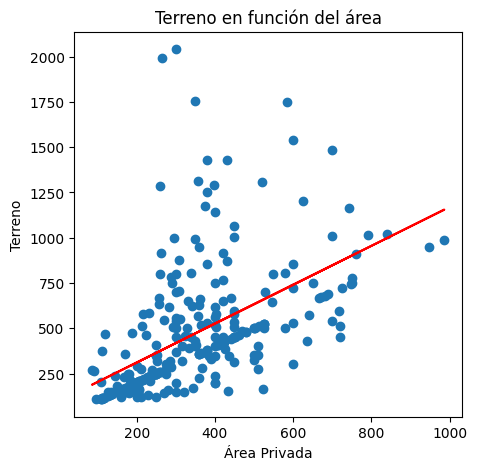

In [256]:
graph_area_relation(houses, houses_ordinal_features + ['Terreno'])

## Preprocesamiento

Se con anterioridad debido al analisis de los datos que en la columna de puestos de estacionamientos hay valores nulos, los cuales voy a limpiar.

In [257]:
houses['Puestos De Estacionamiento'].isnull().sum()

39

In [258]:
houses[(houses['Puestos De Estacionamiento'].isnull()) & (houses['Tipo De Estacionamiento'] != "Ninguno")].head()

,Precio,Codígo RAH,Tipo de Propiedad,Estilo,Área Privada,Terreno,Estado Del Inmueble,Dormitorios,Total Baños,Baños Completos,Tipo De Estacionamiento,Puestos De Estacionamiento,Amoblado,Dormitorio De Servicio,Calle,País,Estado,Ciudad,Urbanización,Medios Baños
15,130000,VE 23-26540,Casa,Multipes Niveles,364,520,Usado,6,5,5,Cubierto,NaN,No,No,Publica,Venezuela,Falcon,Punto Fijo,Puerta Maraven,0.0
20,165000,VE 23-26515,Casa,1 Nivel,690,690,Usado,4,5,5,Cubierto,NaN,No,No,Publica,Venezuela,Lara,Barquisimeto,Parroquia Juan de Villegas,0.0
22,40000,VE 23-26513,Casa,1 Nivel,280,290,Usado,4,4,4,Cubierto,NaN,No,No,Cerrada con Vigilancia,Venezuela,Lara,Cabudare,La Morenera,0.0
45,22000,VE 23-26418,Casa,1 Nivel,191,191,Usado,3,2,2,Cubierto,NaN,Parcialmente,No,Publica,Venezuela,Falcon,Punto Fijo,Puerta Maraven,0.0
55,210000,VE 23-26375,Casa,Multipes Niveles,233,233,Usado,3,2,2,Cubierto,NaN,No,Si,Cerrada con Vigilancia,Venezuela,Distrito Metropolitano,Caracas,El Marques,0.0


In [259]:
# Puestos de estacionamiento nulos cuando el tipo es distinto de ninguno
houses[(houses['Puestos De Estacionamiento'].isnull()) & (houses['Tipo De Estacionamiento'] != "Ninguno")]['Puestos De Estacionamiento'].isnull().sum()

35

In [260]:
# Puestos de estacionamiento nulos cuando el tipo es ninguno (mal cargados)
houses[(houses['Puestos De Estacionamiento'].isnull()) & (houses['Tipo De Estacionamiento'] == "Ninguno")]['Puestos De Estacionamiento'].isnull().sum()

4

In [261]:
mask_no_parking_and_null = (houses['Puestos De Estacionamiento'].isnull()) & (houses['Tipo De Estacionamiento'] == "Ninguno")
# Si el tipo de estacionamiento es ninguno entonces tiene cero puestos de estacionamiento
houses.loc[mask_no_parking_and_null, 'Puestos De Estacionamiento'] = houses.loc[mask_no_parking_and_null, 'Puestos De Estacionamiento'].fillna(0)

In [262]:
mask_parking_but_null = (houses['Puestos De Estacionamiento'].isnull()) & (houses['Tipo De Estacionamiento'] != "Ninguno")
# Si el tipo de estacionamiento es ninguno entonces tiene al menos un puesto de estacionamiento
houses.loc[mask_parking_but_null, 'Puestos De Estacionamiento'] = houses.loc[mask_parking_but_null, 'Puestos De Estacionamiento'].fillna(1)

In [263]:
houses['Puestos De Estacionamiento'].isnull().sum()

0

In [264]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [265]:
houses2 = houses.copy()

In [399]:
houses = houses2

In [400]:
house_numeric_features = ['Área Privada', 'Terreno']
houses_ordinal_features = ['Dormitorios', 'Puestos De Estacionamiento']
houses_categorical_features = ['Ciudad']

In [401]:
# Estandarizacion de columnas numericas
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encoding para columnas categoricas
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combinando preprocesadores
preprocessor = ColumnTransformer(transformers=
                                 [('num', numeric_transformer, house_numeric_features),('cat', categorical_transformer, houses_categorical_features)])

## Entrenamiento

In [402]:
print(house_numeric_features, houses_ordinal_features, houses_categorical_features, sep='\n')

['Área Privada', 'Terreno']
['Dormitorios', 'Puestos De Estacionamiento']
['Ciudad']


In [403]:
# Me quedo solo con las columnas que voy a usar
houses = houses[house_numeric_features + houses_ordinal_features + houses_categorical_features + ['Precio']]

In [404]:
# Separo en datasets de features y label
x_houses, y_houses = houses.drop(labels=['Precio'], axis=1), houses['Precio']
print('Features:',x_houses[:3], '\nLabel:',y_houses[:3].values, sep='\n')

Features:
   Área Privada  Terreno  Dormitorios  Puestos De Estacionamiento   Ciudad
1           184      214            4                         2.0    Cagua
2           545      644            5                         5.0  Caracas
3           290      750            3                         4.0  Caracas

Label:
[ 45000 220000 119000]


In [405]:
from sklearn.model_selection import train_test_split

In [406]:
# Separo en dataframes de entrenamiento y verificacion
x_houses_train, x_houses_test, y_houses_train, y_houses_test = train_test_split(x_houses, y_houses, test_size=0.3, random_state=69)
print(f"Training set: {x_houses_train.shape[0]} filas\nTest set: {x_houses_test.shape[0]} filas")

Training set: 195 filas
Test set: 84 filas


In [407]:
preprocessor.fit(x_houses_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Área Privada', 'Terreno']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Ciudad'])])

In [408]:
x_houses_train_ = preprocessor.transform(x_houses_train)
x_houses_test_ = preprocessor.transform(x_houses_test)

In [409]:
from sklearn.linear_model import LinearRegression

In [438]:
model = LinearRegression().fit(x_houses_train_, y_houses_train)

In [439]:
houses_predictions = model.predict(x_houses_test_)

In [440]:
print('Labels predichas: ', np.round(houses_predictions[:5]))
print('Labels reales: ', y_houses_test[:5].values)

Labels predichas:  [ 84702. 121203. 188686.  48498.  76311.]
Labels reales:  [ 77500  70000 155000  22000  25000]


In [441]:
from sklearn.metrics import mean_squared_error, r2_score

In [442]:
mse = mean_squared_error(y_houses_test, houses_predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_houses_test, houses_predictions)
print("R2:", r2)

MSE: 12543035652.714897
RMSE: 111995.69479544692
R2: 0.425318044151318


El modelo no predice bien el precio, asi que voy a probar con otros modelos.

In [443]:
from sklearn.linear_model import Lasso

In [466]:
model = Lasso(max_iter=12000).fit(x_houses_train_, y_houses_train)

houses_predictions = model.predict(x_houses_test_)

mse = mean_squared_error(y_houses_test, houses_predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_houses_test, houses_predictions)
print("R2:", r2)

MSE: 12531533135.797565
RMSE: 111944.33052101194
R2: 0.425845052851784


In [445]:
from sklearn.ensemble import RandomForestRegressor

In [467]:
model = RandomForestRegressor().fit(x_houses_train_, y_houses_train)

houses_predictions = model.predict(x_houses_test_)

mse = mean_squared_error(y_houses_test, houses_predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_houses_test, houses_predictions)
print("R2:", r2)

MSE: 13221547941.99494
RMSE: 114984.99007259574
R2: 0.39423077147929764


In [447]:
from sklearn.ensemble import GradientBoostingRegressor

In [464]:
model = GradientBoostingRegressor().fit(x_houses_train_, y_houses_train)

houses_predictions = model.predict(x_houses_test_)

mse = mean_squared_error(y_houses_test, houses_predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_houses_test, houses_predictions)
print("R2:", r2)

MSE: 14248508821.893764
RMSE: 119367.1178419491
R2: 0.3471786938658056


Se puede ver como los resultados para todos los modelos son similares, lo que indica que el problema no es del modelo utilizado, sino que los datos disponibles son malos. Entra basura -> sale basura.

Solo para comprobar esta afirmacion, quiero buscar parametros optimos para el ultimo modelo.

In [421]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [465]:
params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3], 'n_estimators' : [10, 25, 50, 75],
    'min_samples_split': [2, 3, 4], 'min_samples_leaf': [2, 3, 4], 'max_depth': [2, 3, 4]}

score = make_scorer(r2_score)
gridsearch = GridSearchCV(GradientBoostingRegressor(), params, scoring=score, cv=3, return_train_score=True)
gridsearch.fit(x_houses_train_, y_houses_train)
print("Mejor combinacion de parametros:", gridsearch.best_params_, "\n")

model=gridsearch.best_estimator_
print(model, "\n")

predictions = model.predict(x_houses_test_)
mse = mean_squared_error(y_houses_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_houses_test, predictions)
print("R2:", r2)

Mejor combinacion de parametros: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 25} 

GradientBoostingRegressor(min_samples_leaf=2, min_samples_split=3,
                          n_estimators=25) 

MSE: 13874956726.22617
RMSE: 117792.00620681426
R2: 0.36429366147758635


A pesar de haber buscado parametros optimos para el modelo de Gradient Boosting, no mejoro mucho su rendimiento. Por esto concluyo que el problema no es el modelo utilizado ni su optimizacion, sino que se necesitaria mas datos de casas para compensar la baja calidad de los datos, y asi obtener mejores predicciones.  
De todas formas, voy a exportar el modelo.

In [194]:
import joblib

In [197]:
joblib.dump(model, './casas-modelo-ml.pkl')

['./casas-modelo-ml.pkl']

# Departamentos

In [204]:
mask_price = ((apartments['Precio'] <= apartments['Precio'].quantile(q=0.95)) & (apartments['Precio'] >= apartments['Precio'].quantile(q=0.05)))
mask_area = ((apartments['Área Privada'] <= apartments['Área Privada'].quantile(q=0.95)) & (apartments['Área Privada'] >= apartments['Área Privada'].quantile(q=0.05)))

apartments = apartments[mask_area & mask_price]

In [205]:
apartments.shape

(300, 18)

In [206]:
apartments.head()

,Precio,Codígo RAH,Tipo de Propiedad,Estilo,Área Privada,Estado Del Inmueble,Dormitorios,Total Baños,Baños Completos,Tipo De Estacionamiento,Puestos De Estacionamiento,Amoblado,Dormitorio De Servicio,País,Estado,Ciudad,Urbanización,Medios Baños
0,85000,VE 23-26228,Apartamento,1 Nivel,140,Usado,3,3,3,Cubierto,4,Si,Si,Venezuela,Distrito Metropolitano,Caracas,Miranda,0.0
1,8000,VE 23-26225,Apartamento,1 Nivel,90,Usado,3,3,3,Cubierto,1,No,No,Venezuela,Zulia,Maracaibo,Avenida Goajira,0.0
2,39500,VE 23-26222,Apartamento,1 Nivel,115,Usado,3,2,2,Cubierto,2,No,No,Venezuela,Aragua,Maracay,La Romana,0.0
3,280000,VE 23-26219,Apartamento,1 Nivel,197,Usado,5,4,4,Cubierto,2,Parcialmente,No,Venezuela,Distrito Metropolitano,Caracas,La Tahona,0.0
4,115000,VE 23-26218,Apartamento,1 Nivel,69,Usado,1,2,2,Cubierto,1,Si,No,Venezuela,Distrito Metropolitano,Caracas,Colinas de Bello Monte,0.0


Como para las casas, voy a elegir las columnas que parecen ser utiles para el modelo y graficarlas para averiguar si realmente son o no utiles.

In [209]:
apartments_num_features = ['Área Privada']
apartments_ord_features = ['Dormitorios', 'Total Baños', 'Puestos De Estacionamiento']
apartments_cat_fatures = ['Estilo', 'Estado Del Inmueble', 'Tipo De Estacionamiento', 'Amoblado', 'Dormitorio De Servicio', 'Estado', 'Ciudad']

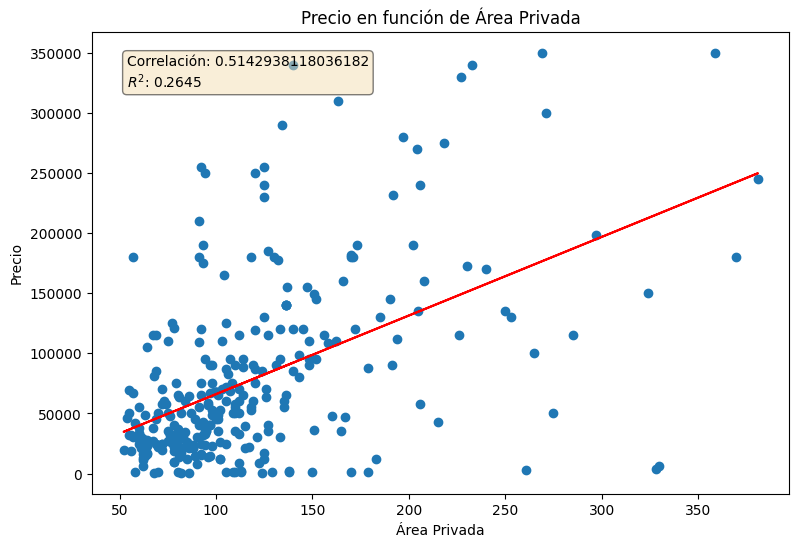

In [210]:
graph_numeric_relations(apartments, apartments_num_features)

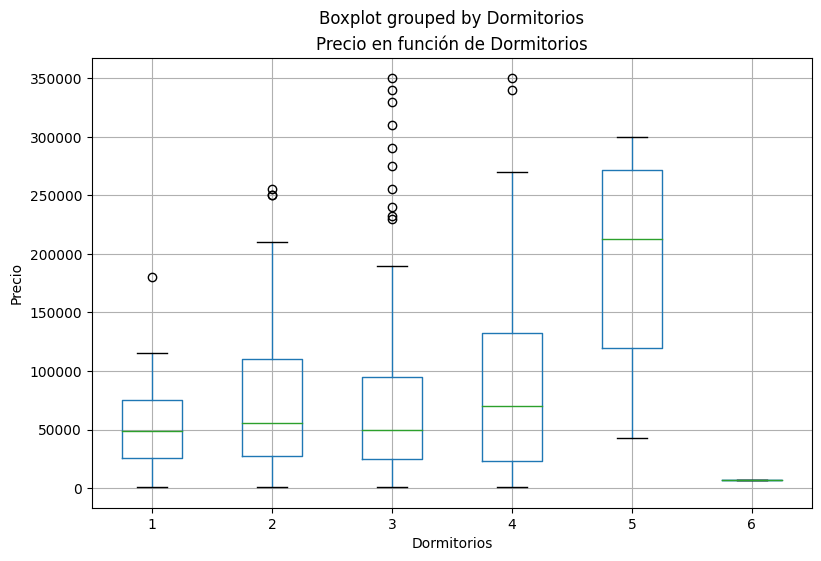

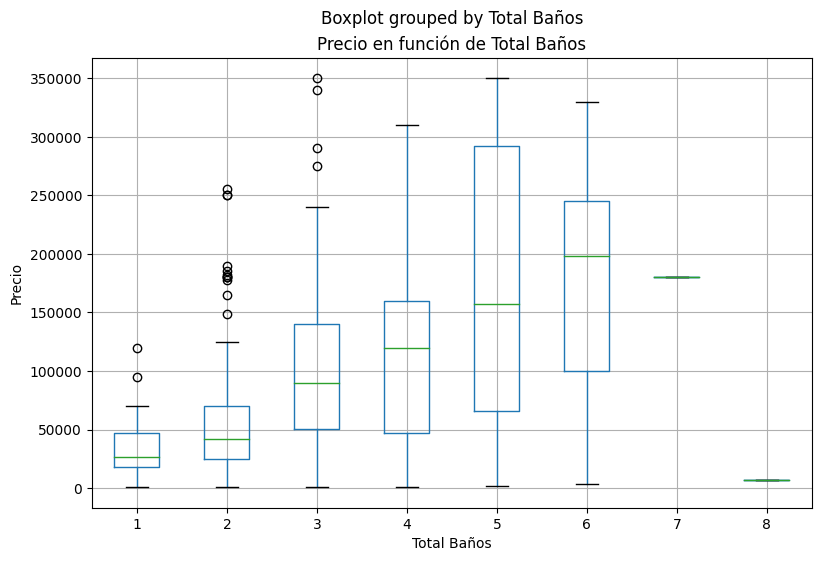

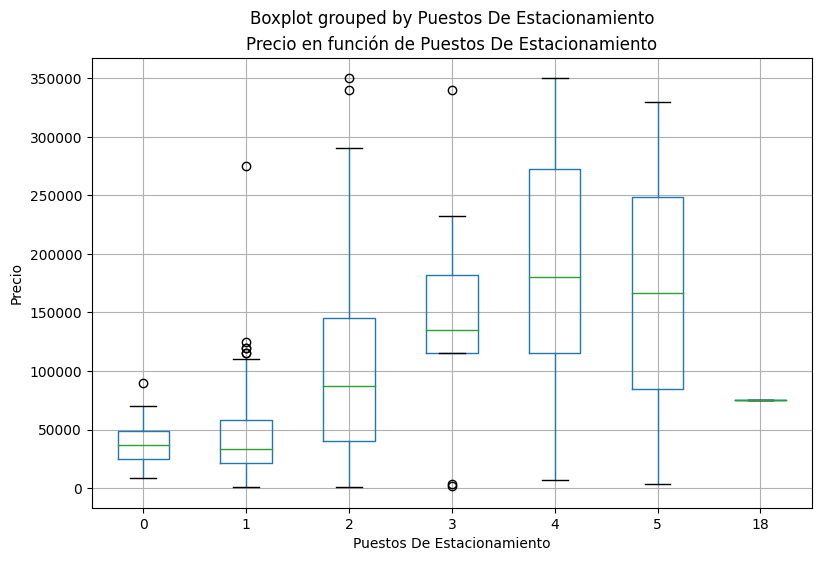

In [211]:
graph_categorical_relations(apartments, apartments_ord_features)

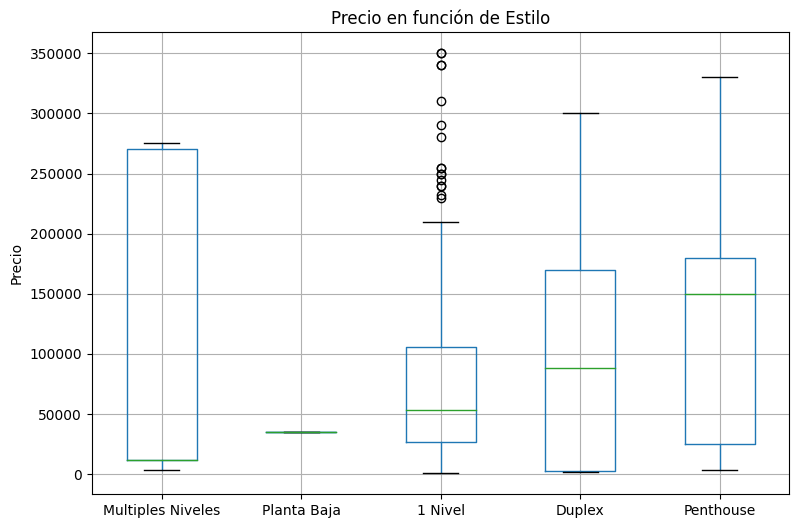

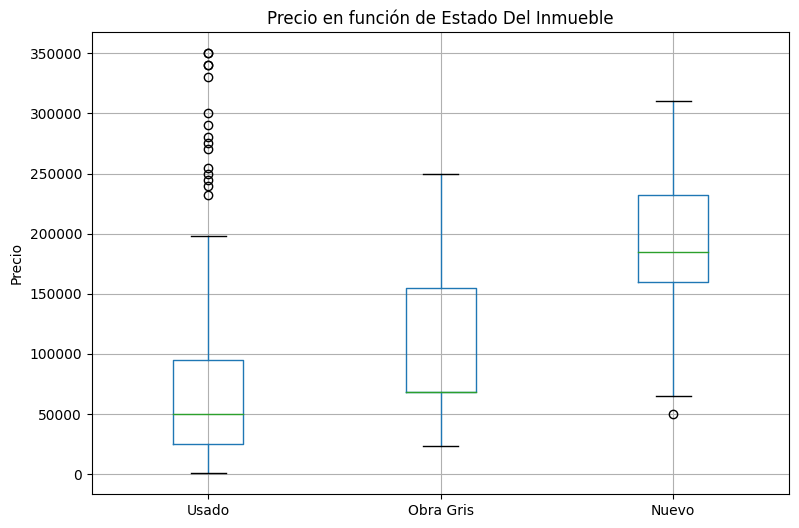

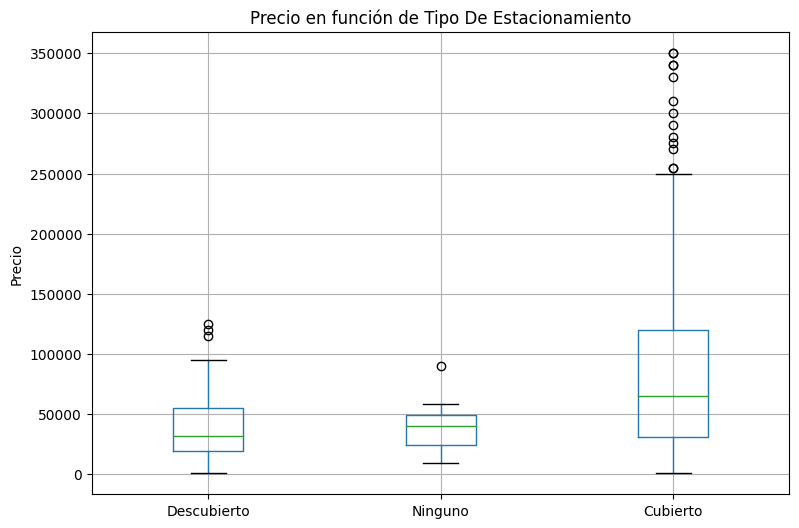

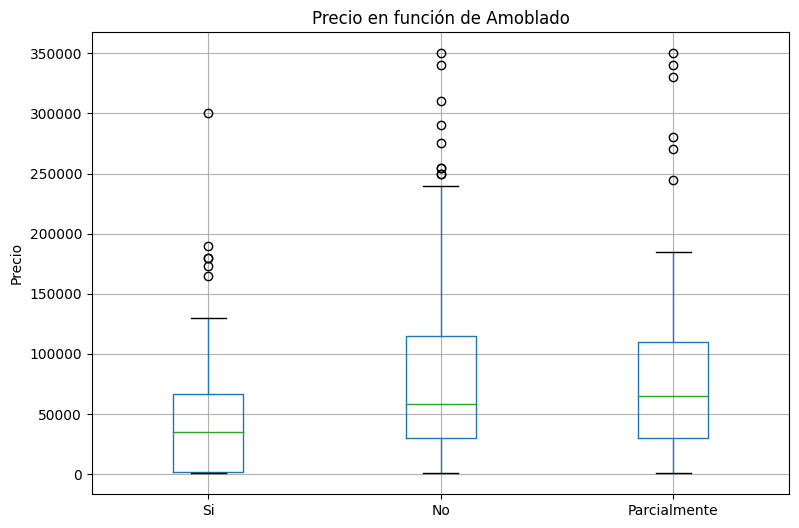

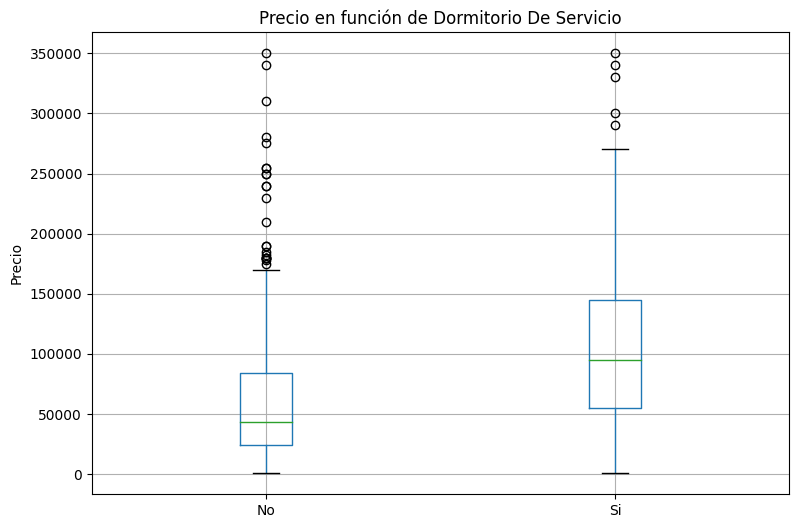

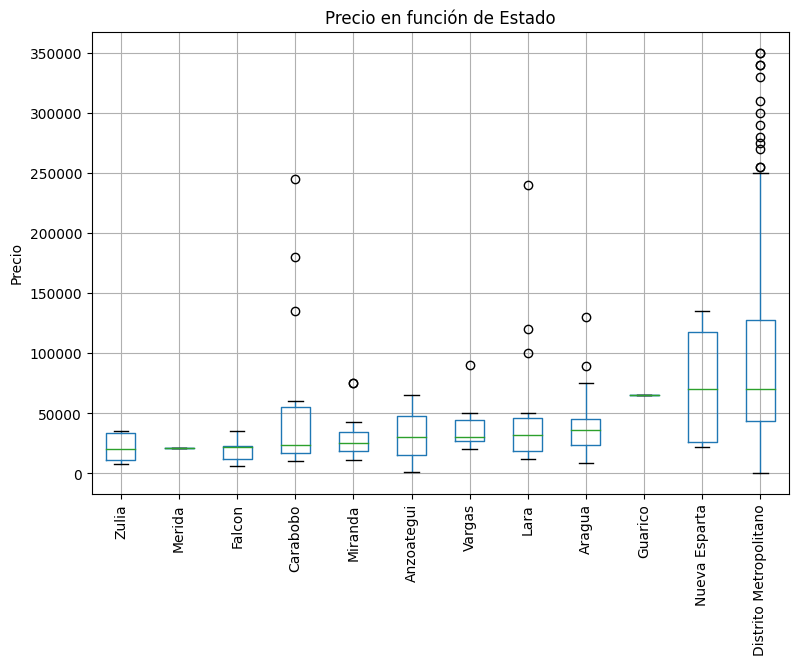

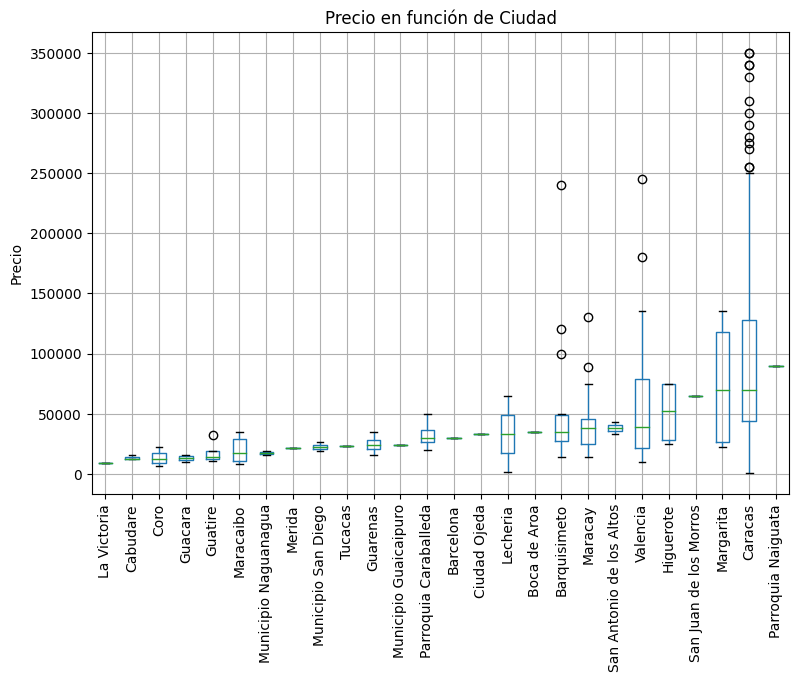

In [212]:
graph_categorical_relations(apartments, apartments_cat_fatures)